# Supervised Machine Learning with PySpark

In [6]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 51 kB/s 
     |████████████████████████████████| 199 kB 63.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=4493881b8be4e97a99afc2e4419863541c7b81e9b86bfa5d8a003230d94f5305
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


This dataset has 119391 rows and 32 columns.

In [7]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import pyspark
from pyspark.sql import functions as F
from pyspark.sql import types

from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor, GBTRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

warnings.filterwarnings('ignore')

# Connect to the Spark server

In [8]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

# Obtain the Data

In [9]:
fullpath = 'hotel_bookings.csv'

data = spark.read.csv(fullpath)

In [10]:
data

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string, _c21: string, _c22: string, _c23: string, _c24: string, _c25: string, _c26: string, _c27: string, _c28: string, _c29: string, _c30: string, _c31: string]

In [11]:
# read.csv is very similar to the Pandas version
data = spark.read.csv(fullpath,
                     sep=',',
                     inferSchema=True,
                     header=True,
                     multiLine=True)

data.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullab

# Data Cleaning

 drop unnecessary columns 

In [12]:
# these columns are useless to us, drop them
drop_cols = ['arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights']

data = data.drop(*drop_cols)

In [13]:
data = data.replace('other', None, subset=['company'])

In [21]:
data = data.replace('other', None, subset=['arrival_date_month'])

In [ ]:
data = data.replace('other', None, subset=['agent'])

In [15]:
data = data.replace('missing', None, subset=['customer_type'])

# Descriptive Statistics

In [23]:
data.select('arrival_date_year', 'arrival_date_week_number','arrival_date_day_of_month').summary().show()

+-------+------------------+------------------------+-------------------------+
|summary| arrival_date_year|arrival_date_week_number|arrival_date_day_of_month|
+-------+------------------+------------------------+-------------------------+
|  count|            119390|                  119390|                   119390|
|   mean| 2016.156554150264|       27.16517296255968|       15.798241058715135|
| stddev|0.7074759445234089|      13.605138355497662|        8.780829470578274|
|    min|              2015|                       1|                        1|
|    25%|              2016|                      16|                        8|
|    50%|              2016|                      28|                       16|
|    75%|              2017|                      38|                       23|
|    max|              2017|                      53|                       31|
+-------+------------------+------------------------+-------------------------+



# Data Exploration

In [24]:
data.registerTempTable('data')

state_counts = spark.sql(r"""SELECT arrival_date_month, COUNT(arrival_date_month) AS total 
                                     FROM data 
                                     GROUP BY arrival_date_month 
                                     ORDER BY total desc """)
state_counts.show()

+------------------+-----+
|arrival_date_month|total|
+------------------+-----+
|            August|13877|
|              July|12661|
|               May|11791|
|           October|11160|
|             April|11089|
|              June|10939|
|         September|10508|
|             March| 9794|
|          February| 8068|
|          November| 6794|
|          December| 6780|
|           January| 5929|
+------------------+-----+



In [25]:
mfr_counts = spark.sql(r"""SELECT meal, COUNT(meal) as total
                                  FROM data
                                  GROUP BY meal
                                  ORDER BY total desc""")

mfr_counts.show()

+---------+-----+
|     meal|total|
+---------+-----+
|       BB|92310|
|       HB|14463|
|       SC|10650|
|Undefined| 1169|
|       FB|  798|
+---------+-----+



### Histogram

In [26]:

df_result = spark.sql('SELECT meal, arrival_date_month FROM data WHERE meal IN ("BB", "HB", "SC")')
df_result = df_result.toPandas()

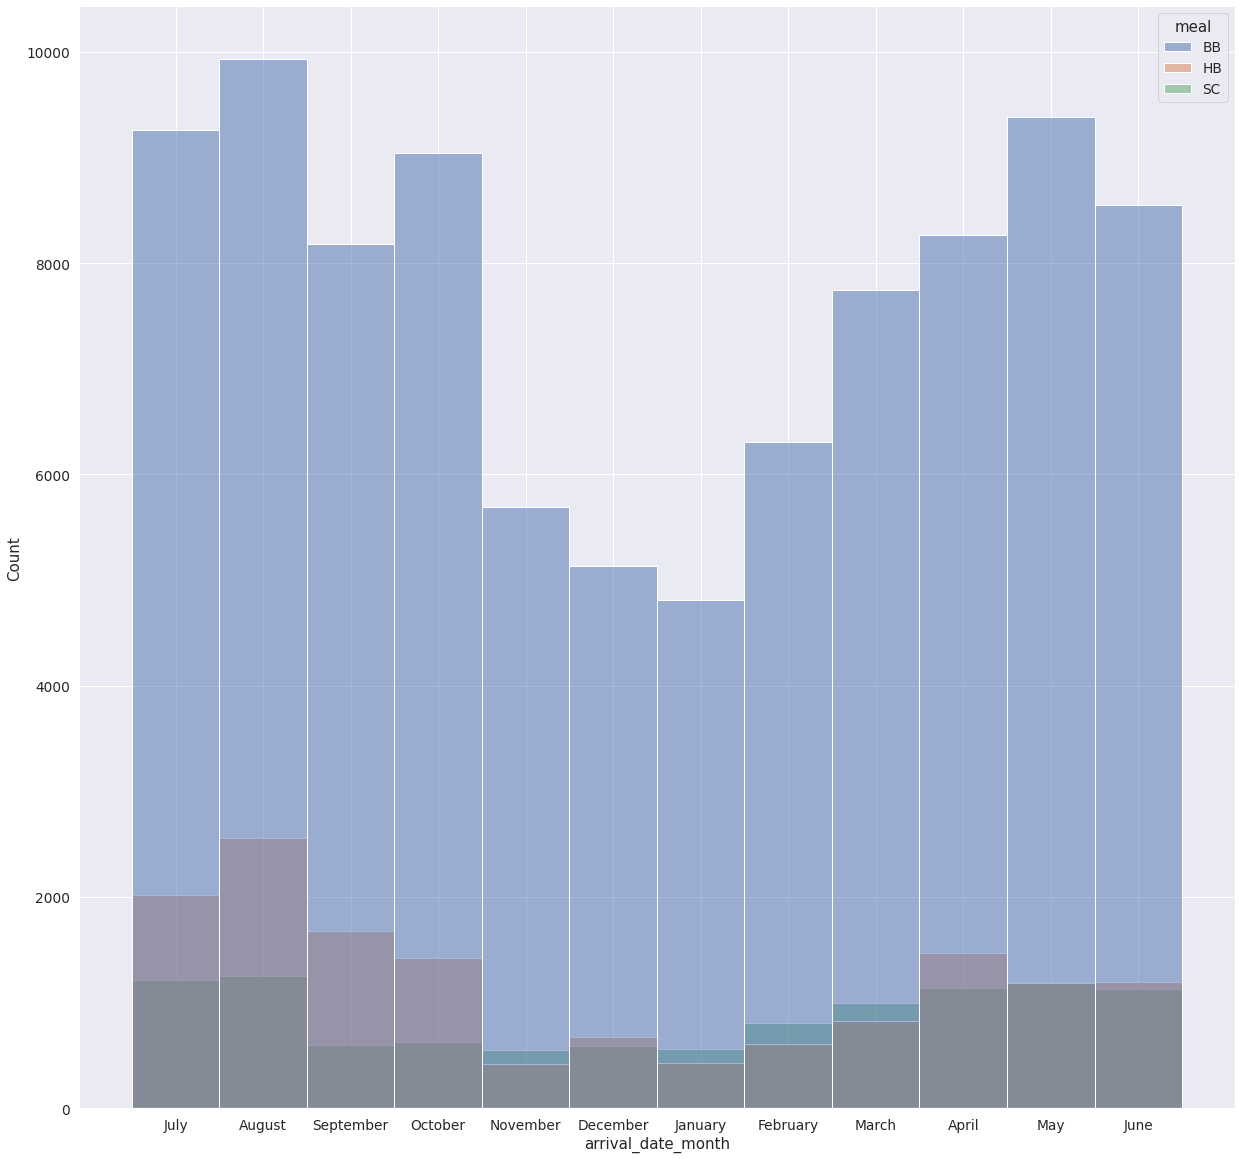

In [32]:
sns.set_context("notebook", font_scale=1.25)
sns.histplot(data=df_result, x='arrival_date_month', hue='meal', binwidth=0.3)
sns.set(rc={'figure.figsize':(30.7,20.27)})

# Scatter Plot

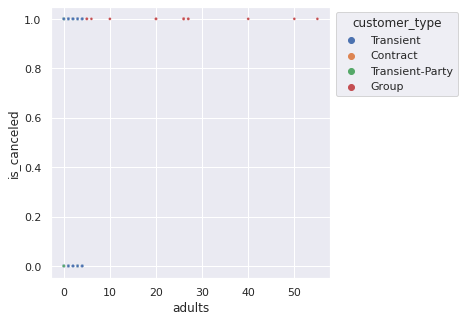

In [38]:
df_result = spark.sql('SELECT customer_type, adults, is_canceled FROM data')
df_result = df_result.toPandas()
ax = sns.scatterplot(data=df_result, x='adults', y='is_canceled', hue='customer_type', s=8)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.set(rc={'figure.figsize':(2,3)})

# Pie Chart

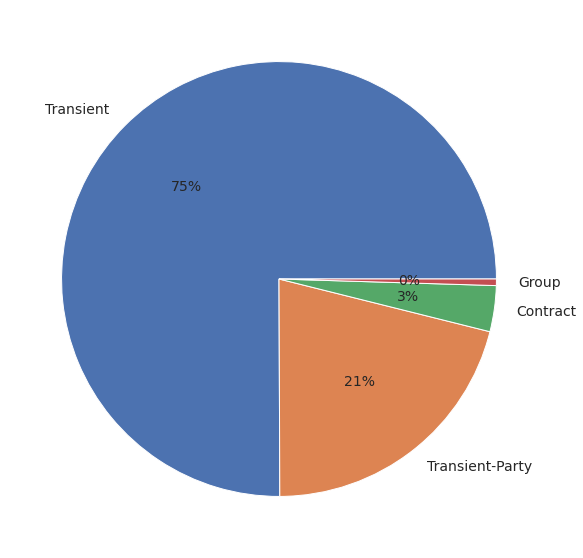

In [42]:
df_result = spark.sql('SELECT customer_type FROM data')
df_result = df_result.toPandas()
df_result_c = df_result['customer_type'].value_counts().nlargest(4)
colors = sns.color_palette('deep')
sns.set(rc={'figure.figsize':(10,10)})
plt.pie(df_result_c.values, labels=df_result_c.index, colors=colors, autopct='%.0f%%', textprops={'fontsize': 14})
plt.show()

### Pairplot


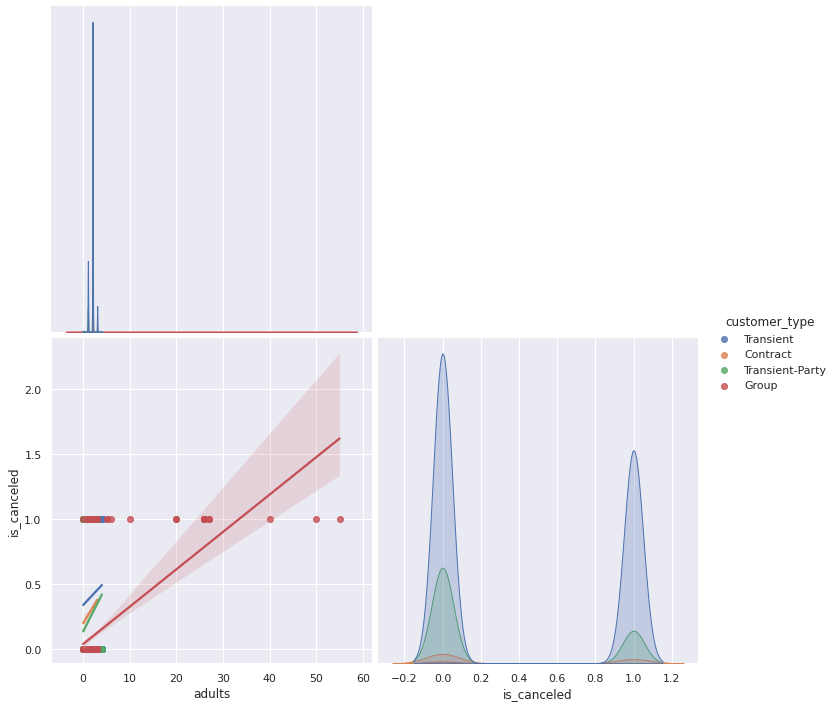

In [44]:
df_result = spark.sql('SELECT customer_type, adults, arrival_date_month, is_canceled FROM data')
df_result = df_result.toPandas()
sns.pairplot(df_result, kind='reg', hue='customer_type', corner=True, size=5)

## Data Preparation for ML

# Category Dropping

In [47]:
cat_cols = ['hotel', 'arrival_date_month', 'children', 'meal', \
            'country', 'market_segment', 'distribution_channel', 'reserved_room_type',\
           'assigned_room_type', 'deposit_type', 'agent', 'company', 'customer_type', 'reservation_status']

n = 32

for col in cat_cols:
    most_freq = data.groupBy(col).count().orderBy('count', ascending=False).take(n - 1)
    most_freq = spark.createDataFrame(most_freq).toPandas()
    most_freq = most_freq[col].tolist()

    data = data.withColumn(col, F.when(F.col(col).isin(most_freq), F.col(col)))

### Imputation


In [48]:
num_cols = ['is_canceled', 'lead_time', 'arrival_date_year', 'babies', 'is_repeated_guest', 'booking_changes']

imputer = Imputer(inputCols=num_cols, outputCols=num_cols, strategy='mean')
model = imputer.fit(data)
data = model.transform(data)

In [49]:
data = data.fillna('unknown', subset=cat_cols)

In [50]:
for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+'_idx')
    data = indexer.fit(data).transform(data)
    
data = data.drop(*cat_cols)

# Combining Feature Columns

**Value indicating if the booking was canceled (1) or not (0)**


In [53]:
cols = data.columns
cols.remove('is_canceled') #remove is_canceled -> we need this to be our label
cols.remove('reservation_status_date') #remove 

assembler = VectorAssembler(inputCols=cols, outputCol='features')

data = assembler.transform(data)

# Set columns and Split

In [54]:
# We have created a new dataframe only consisting of the features column and the label column (actually price column but renamed)
df_data = data.select(F.col('features'), F.col('is_canceled').alias('label'))

df_train, df_test = df_data.randomSplit([0.8, 0.2])

# Model Building

In [55]:
evaluator = RegressionEvaluator() # Can specify what metrics we want to use. Default metric is Root Mean Squared Error (RMSE)
grid = ParamGridBuilder().build()

# Initialize Regressors and Train

In [56]:
#Random Forest Regressor
classifier_rf = RandomForestRegressor(featuresCol='features', labelCol='label')
cv_rf = CrossValidator(estimator=classifier_rf, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv_model_rf = cv_rf.fit(df_train)

In [57]:
#Gradient Boosted Tree Regressor
classifier_gbt = GBTRegressor(featuresCol="features", labelCol='label', maxIter=10)
cv_gbt = CrossValidator(estimator=classifier_gbt, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv_model_gbt = cv_gbt.fit(df_train)

In [58]:
#Linear Regression
classifier_lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
cv_lr = CrossValidator(estimator=classifier_lr, evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cv_model_lr = cv_lr.fit(df_train)

### Evaluation


In [60]:
metrics = []
models = [cv_model_rf, cv_model_gbt, cv_model_lr]

for model in models:
    metrics.append(model.avgMetrics)
print (metrics)

for idx, model in enumerate(models): 
    metrics[idx].append(RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='r2').evaluate(model.bestModel.transform(df_test)))
    metrics[idx].append(RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='rmse').evaluate(model.bestModel.transform(df_test)))
    metrics[idx].append(RegressionEvaluator(predictionCol='prediction', labelCol='label', metricName='mae').evaluate(model.bestModel.transform(df_test)))

df = pd.DataFrame(metrics, index = ['Random Forest Regressor', 'Gradient Boosted Tree Regressor',  'Linear Regression'], columns=['Average Metrics (CV)', 'Best Model R2 on Test Set', 'Best Model RMSE on Test Set', 'Best Model MAE on Test Set'])

df

[[0.05483103626995002], [0.0], [0.2825308120300285]]


,Average Metrics (CV),Best Model R2 on Test Set,Best Model RMSE on Test Set,Best Model MAE on Test Set
Random Forest Regressor,0.054831,0.986977,0.05513,0.039891
Gradient Boosted Tree Regressor,0.000000,1.000000,0.00000,0.000000
Linear Regression,0.282531,0.656820,0.28301,0.271241
